In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import seaborn as sns

In [2]:
plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 1.6

In [3]:
src = "Deuteron/data/"

In [132]:
df = pd.read_csv("deuteron_all_data.csv")
df_exp = pd.read_csv("deuteron_all_exp.csv")

In [70]:
df_exp.head()

,angle,value,error,fname,energy
0,37.904192,5.492080,0.212168,Exp100_2.dat,100
1,42.754491,6.117786,0.243339,Exp100_2.dat,100
2,56.227545,6.783924,0.249610,Exp100_2.dat,100
3,60.179641,5.612127,0.237129,Exp100_2.dat,100
4,83.532934,6.244248,0.318253,Exp100_2.dat,100


In [86]:
df_exp[df_exp.energy == 100].fname.unique()

array(['Exp100_2.dat', 'Exp100n.dat', 'Exp100.dat', 'Exp100_3.dat'],
      dtype=object)

In [6]:
observables = [ob for ob in df.columns.values if ob not in ["THCM", "angle", "CUTOFF", "FORCE"]]

In [7]:
print(observables)

['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


In [8]:
FORCES=["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF=[400,450,500,550]

In [24]:
line_styles = {"LO": {"marker":"d", "markevery": 10, "markersize": 3, "color": "tab:orange"},
               "NLO": {"marker":".", "markevery": 10, "color": "tab:blue"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "tab:green"},
               "N3LO": {"ls": "dotted", "color": "tab:red"},
               "N4LO": {"color": "black"},
               "N4LO+": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "tab:cyan"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "tab:pink"}
              }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"], 
            }

In [98]:
markers = ["o", "s", "^", "x"]

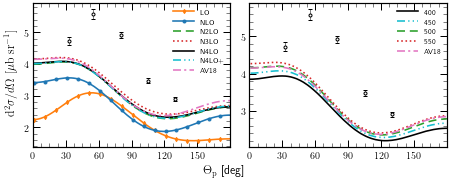

In [131]:
obs="CROSS2"
ylabel="$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"
energy=140

fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)
fig.supylabel(ylabel, x=0.03, y=0.6, size=12)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) & (df.CUTOFF == 450) & (df.Energy == energy) & (df.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                 **line_styles[force], label = force)
for cutoff in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") & (df.CUTOFF == cutoff) & (df.Energy == energy) & (df.WAVE == "SIEGERT")]
    axes[1].plot(df_tmp.angle, df_tmp[obs],
                 **ls_cutoff[cutoff], label = cutoff)
df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for ax in axes:
    ax.plot(df_av18.angle, df_av18[obs],
                 **line_styles["AV18"], label = "AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == energy].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == energy) & (df_exp.fname == fname)]
        ax.errorbar(df_tmp.angle, df_tmp.value,
                    yerr=df_tmp.error, fmt=f"{markers[i]}k",
                    markersize=3, markerfacecolor="white", markeredgecolor="k",
                   elinewidth=0.5, capsize=2, zorder=3);
    # style
    ax.legend(fontsize=7, handlelength=3)
    ax.tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
    ax.set_xticks(np.arange(0,180,30))
    ax.set_xlim([0,180])
    # ax.set_ylim([1.5,4.5])
# axes[1].set_ylim(axes[0].get_ylim())
    # ax.grid()
# plt.subplots_adjust(wspace = 0.001)
fig.tight_layout()
plt.savefig(f"Figures_python/{obs}_{energy}mev.pdf", dpi=600, facecolor="white")
plt.show()

# Integrate

In [183]:
df_tmp = df[(df.FORCE == "N4LO+") &
            (df.CUTOFF == 450) &
            (df.Energy == 140) &
            (df.WAVE == "SIEGERT")]


In [164]:
x = df_tmp.angle.values
y = df_tmp.CROSS2.values

In [158]:
from scipy.integrate import simpson

In [165]:
2*np.pi*simpson(y,x=np.deg2rad(x))

404.7751217476615

In [138]:
df_arends = pd.read_csv("data_arends1984.csv", header=None, names=["energy", "cross_tot"])

In [184]:
df_tmp.iloc[(df_tmp['angle']-88).abs().argsort()[:1]].T20D2

4407    0.5714
Name: T20D2, dtype: float64

In [175]:
x = df_tmp[(df_tmp['angle']> 24) & (df_tmp['angle'] < 48)].angle.values
y = df_tmp[(df_tmp['angle']> 24) & (df_tmp['angle'] < 48)].T22D2.values

In [176]:
2*np.pi*simpson(y,x=np.deg2rad(x))

0.27371446993721865